# Project: Advanced Lane Finding



## Imports, named constans and parameters


In [1295]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Named constants
CHESSBOARD_IMAGE = 'camera_cal/calibration2.jpg'
TEST_IMAGE = 'test_images/straight_lines2.jpg'
OUTPUT_IMAGE_DIR = 'output_images'

# Parameters
# Boxes in the chessboard
NX = 9
NY = 6

# Lane width and height in pixels
X_PIXELS = 600
Y_PIXELS = 720

# Meters per pixel in x and y dimension
X_METERS_PER_PIXEL = 3.7/X_PIXELS     
Y_METERS_PER_PIXEL = 30/Y_PIXELS

# Horizontal and vertical center in meters
H_CENTER = (1280/2) * X_METERS_PER_PIXEL
V_CENTER = (720/2) * Y_METERS_PER_PIXEL


## Step 1

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.

### Step 1 Functions


In [1296]:
def collectCorners(imageFiles, nx, ny):
    '''
    Collect object points and image points from the chessboard images
    '''
    objPoints = []
    imagePoints = []

    objPoint = np.zeros((ny*nx,3), np.float32)
    objPoint[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for imageFile in imageFiles:
        image = mpimg.imread(imageFile)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            objPoints.append(objPoint)
            imagePoints.append(corners)
            
    return objPoints,imagePoints

def undistort(image, objPoints, imagePoints):
    '''
    Create an undistorted image given the object points and image points
    '''
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imagePoints, (image.shape[1], image.shape[0]), None, None)
    return cv2.undistort(image, mtx, dist, None, mtx)

### Step 1 Test

* Camera calibration
* Undistortion of an image


In [1297]:
imageFiles = glob.glob('camera_cal/*.jpg')
objPoints,imagePoints = collectCorners(imageFiles, NX, NY)

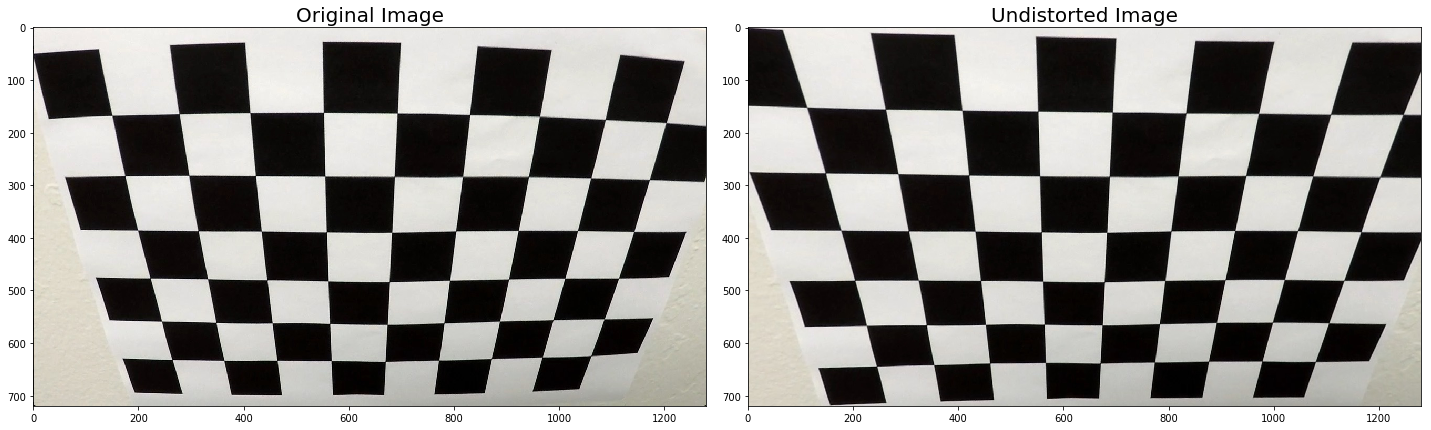

In [1298]:
chessboard = mpimg.imread(CHESSBOARD_IMAGE)
undistorted_chessboard = undistort(chessboard, objPoints, imagePoints)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout()
ax1.imshow(chessboard, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted_chessboard, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'undistorted_chessboard.jpg'))

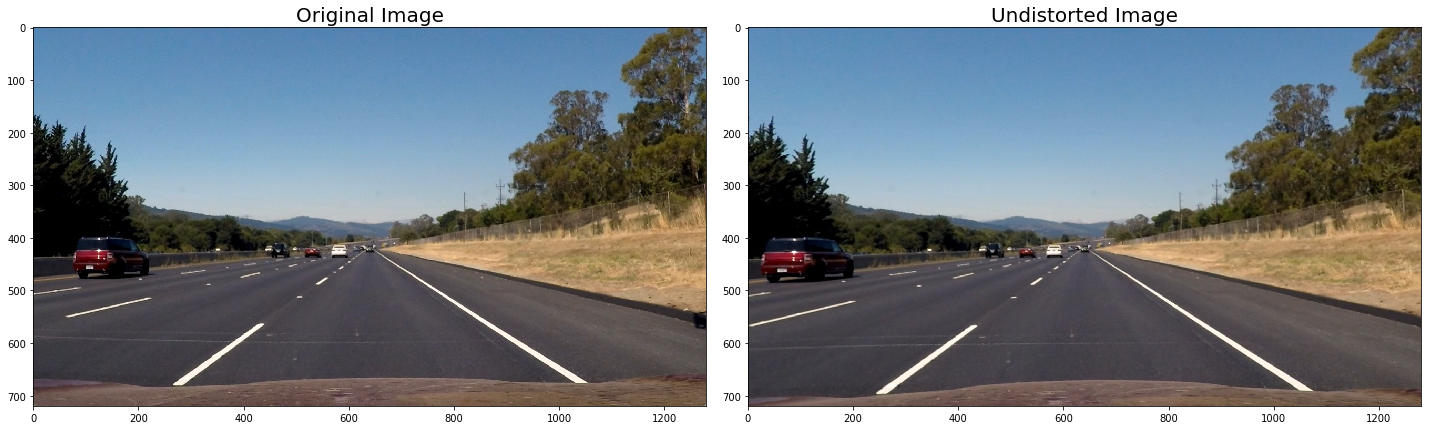

In [1299]:
image = mpimg.imread(TEST_IMAGE)
undistorted = undistort(image, objPoints, imagePoints)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout()
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'undistorted.jpg'))

## Step 2

* Create a thresholded binary image using color transforms and gradients.

### Step 2 Functions


In [1300]:
def thresholdColorGradient(undistorted, sThreshold=(130,255), xThreshold=(15,100)):
    '''
    Create thresholded binary images using color transforms and gradients given the undistorted image and thesholds
    '''
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS).astype(np.float)
    lChannel = hls[:,:,1]
    sChannel = hls[:,:,2]

    # Take the derivative in x using the Sobel operator
    # Absolute x derivative to accentuate lines away from horizontal
    sobelX = cv2.Sobel(lChannel, cv2.CV_64F, 1, 0)
    absSobelX = np.absolute(sobelX)
    xSobel = np.uint8(255 * absSobelX/np.max(absSobelX))

    # Threshold x gradient
    xBinary = np.zeros_like(xSobel)
    xBinary[(xThreshold[0] <= xSobel) & (xSobel <= xThreshold[1])] = 1

    # Threshold color channel
    sBinary = np.zeros_like(sChannel)
    sBinary[(sThreshold[0] <= sChannel) & (sChannel <= sThreshold[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    colorBinary = np.dstack((np.zeros_like(xBinary), xBinary, sBinary))

    # Combine the two binary thresholds
    combinedBinary = np.zeros_like(xBinary)
    combinedBinary[(sBinary == 1) | (xBinary == 1)] = 1

    return combinedBinary,colorBinary

### Step 2 Test

* Creation of thresholded binary images


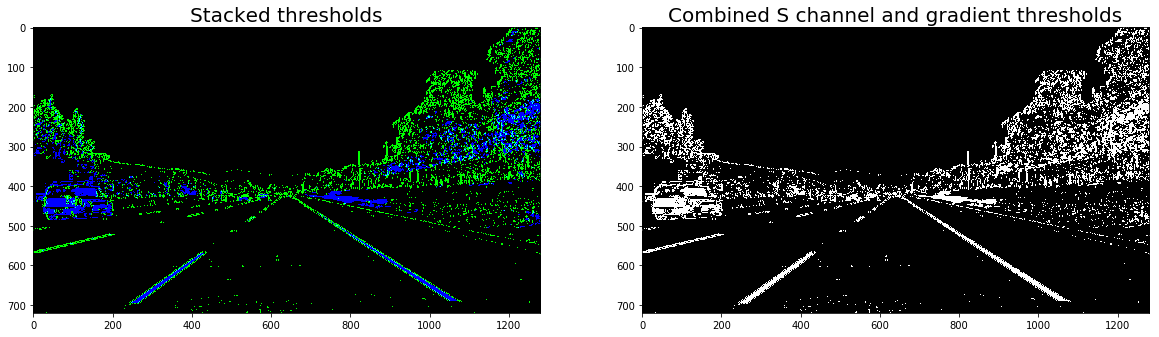

In [1301]:
combinedBinary,colorBinary = thresholdColorGradient(undistorted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax2.set_title('Combined S channel and gradient thresholds', fontsize=20)
ax2.imshow(combinedBinary, cmap='gray')

ax1.set_title('Stacked thresholds', fontsize=20)
ax1.imshow(colorBinary)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'binary.jpg'))

## Step 3

* Set a region where a perspective transform is applied. The region is a fixed one at this point.
* Apply the perspective transform to rectify binary image.


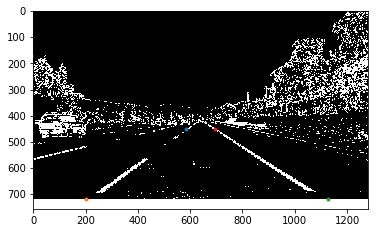

In [1302]:
imageSize = (combinedBinary.shape[1], combinedBinary.shape[0]) 

srcUpperLeft = [(imageSize[0] / 2) - 55, imageSize[1] / 2 + 100]
srcLowerLeft = [((imageSize[0] / 6) - 10), imageSize[1]]
srcLowerRight = [(imageSize[0] * 5 / 6) + 60, imageSize[1]]
srcUpperRight = [(imageSize[0] / 2 + 55), imageSize[1] / 2 + 100]

dstUpperLeft = [(imageSize[0] / 4), 0]
dstLowerLeft = [(imageSize[0] / 4), imageSize[1]]
dstLowerRight = [(imageSize[0] * 3 / 4), imageSize[1]]
dstUpperRight = [(imageSize[0] * 3 / 4), 0]

plt.imshow(combinedBinary, cmap='gray')
plt.plot(srcUpperLeft[0],upperLeft[1],".")
plt.plot(srcLowerLeft[0], lowerLeft[1], ".")
plt.plot(srcLowerRight[0], lowerRight[1], ".")
plt.plot(srcUpperRight[0],upperRight[1],".")

### Step 3 Functions


In [1303]:
def warp(undistorted):
    '''
    Apply the perspective transform to the undistorted binary image
    Return the inverse perspective transform matrix as well as the transformed image
    '''
    # The source region determined above
    src = np.float32(
        [srcUpperLeft,
         srcLowerLeft,
         srcLowerRight,
         srcUpperRight])
    
    # The destination region
    dst = np.float32(
        [dstUpperLeft,
         dstLowerLeft,
         dstLowerRight,
         dstUpperRight])
    
    # Calculate the perspective transform matrix given src and dst points
    # Calculate the inverse perspective transform matrix given src and dst points
    # Warp the image
    imageSize = (undistorted.shape[1], undistorted.shape[0])
    perspective = cv2.getPerspectiveTransform(src, dst)
    inversePerspective = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undistorted, perspective, imageSize, flags=cv2.INTER_LINEAR)
    
    return warped, inversePerspective

### Step 3 Test

* The perspective transform to the undistorted binary image


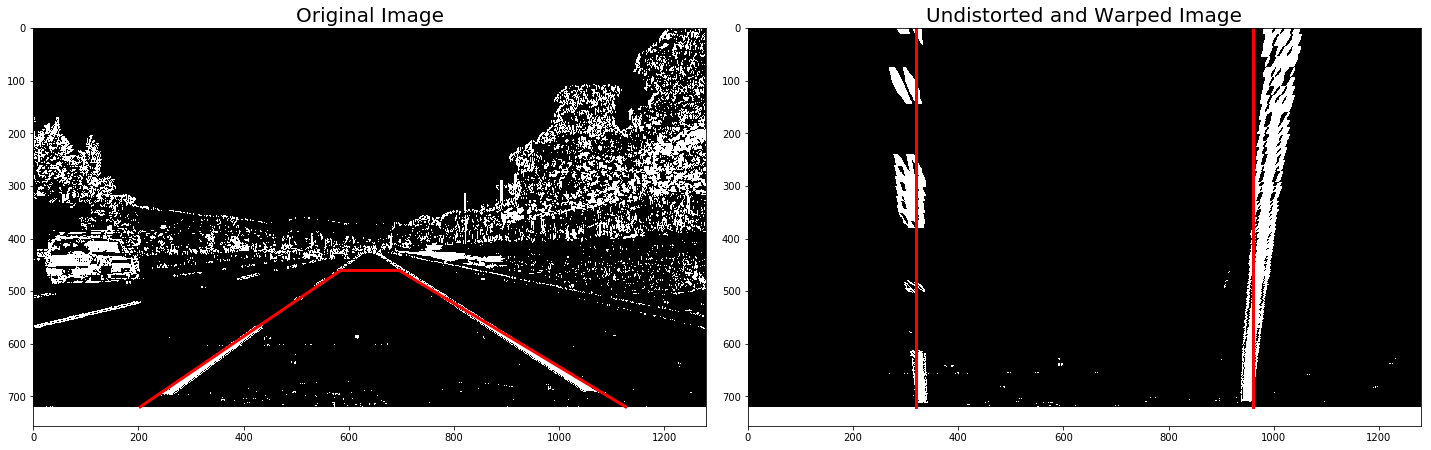

In [1304]:
warped, inversePerspective = warp(combinedBinary)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout()

color = 'red'
linewidth = 3

ax1.imshow(combinedBinary, cmap='gray')
ax1.plot([srcLowerLeft[0], srcUpperLeft[0]], [srcLowerLeft[1], srcUpperLeft[1]], color=color, linewidth=linewidth)
ax1.plot([srcLowerRight[0], srcUpperRight[0]], [srcLowerRight[1], srcUpperRight[1]], color=color, linewidth=linewidth)
ax1.plot([srcUpperLeft[0], srcUpperRight[0]], [srcUpperLeft[1], srcUpperRight[1]], color=color, linewidth=linewidth)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=20)
ax2.plot([dstLowerLeft[0], dstUpperLeft[0]], [dstLowerLeft[1], dstUpperLeft[1]], color=color, linewidth=linewidth)
ax2.plot([dstLowerRight[0], dstUpperRight[0]], [dstLowerRight[1], dstUpperRight[1]], color=color, linewidth=linewidth)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'warped_binary.jpg'))

## Step 4

* Check a histogram of pixels of the undistorted binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.


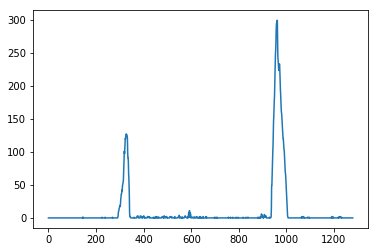

In [1305]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### Step 4 Functions


In [1306]:
# Functions to calculate radii of curvature

def curveRadius(fitted, yValue, Y_METERS_PER_PIXEL):
    return ((1 + (2 * fitted[0] * yValue * Y_METERS_PER_PIXEL + fitted[1])**2)**1.5) / np.absolute(2 * fitted[0])


def polynomial(fitted, plotY):
    return fitted[0] * plotY**2 + fitted[1] * plotY + fitted[2]


def measureCarvature(leftX, leftY, rightX, rightY, plotY):
    '''
    Calculate radii of curvature in meters
    '''    
    # Fit polynomials to x,y
    leftFit = np.polyfit(leftY * Y_METERS_PER_PIXEL, leftX * X_METERS_PER_PIXEL, 2)
    rightFit = np.polyfit(rightY * Y_METERS_PER_PIXEL, rightX * X_METERS_PER_PIXEL, 2)
    
    # Calculate the vehicle potision from the center
    # Calculate the vertical and horizontal center as the lane center
    # Then calculate the vehicle position
    # Negative value: left from center
    # Positive value: right from center
    left = polynomial(leftFit, V_CENTER)
    right = polynomial(rightFit, V_CENTER)
    position = H_CENTER - ((left + right)/2.0)
    
    # Calculate the radii of curvature in meters
    yValue = np.max(plotY)    
    leftCurveRadius = curveRadius(leftFit, yValue, Y_METERS_PER_PIXEL)
    rightCurveRadius = curveRadius(rightFit, yValue, Y_METERS_PER_PIXEL)
    
    return leftCurveRadius, rightCurveRadius, position


# Function to find lanes

def firstFrameProcessed():
    '''
    Flag to see if the first frame of a video is processed
    '''
    firstFrameProcessed.done = True
    
    
def fitted(left, right):
    '''
    Store coefficients of the polynomials
    '''
    fitted.left = left
    fitted.right = right

    
def nonzeroIndices(lowX, highX, lowY, highY, nonzeroX, nonzeroY):
    '''
    Return indices of nonzero pixels given the low and high indices
    '''
    return ((lowY <= nonzeroY) & (nonzeroY < highY) & (lowX <= nonzeroX) & (nonzeroX < highX)).nonzero()[0]


def laneIndices(fitted, nonzeroX, nonzeroY, margin):
    '''
    Return indices around the plynomials given the margin
    '''
    def laneIndex(fitted, nonzeroX, nonzeroY, margin):
        return (((fitted[0]*(nonzeroY**2) + fitted[1]*nonzeroY + fitted[2] - margin) < nonzeroX) &
            (nonzeroX < (fitted[0]*(nonzeroY**2) + fitted[1]*nonzeroY + fitted[2] + margin)))
    
    leftLaneIndices = laneIndex(fitted.left, nonzeroX, nonzeroY, margin)
    rightLaneIndices = laneIndex(fitted.right, nonzeroX, nonzeroY, margin)
    
    return leftLaneIndices, rightLaneIndices


def laneFits(fitted, plotY):
    '''
    Calculate the value of the polynomials
    '''
    leftFit = polynomial(fitted.left, plotY)
    rightFit = polynomial(fitted.right, plotY)
    
    return leftFit, rightFit


def findLanes(warped, numberOfWindows=9, windowMargin=100, minPixels=50):
    '''
    Find lanes in the undistorted binary image using the sliding window
    '''
    # Left and right lane pixel indices
    leftLaneIndices = []
    rightLaneIndices = []
    
    # Left and right lane pixel positions
    leftX = []
    leftY = []
    rightX = []
    rightY = []
      
    # Identify the x and y positions of all nonzero pixels in the image first
    nonzero = warped.nonzero()
    nonzeroY = np.array(nonzero[0])
    nonzeroX = np.array(nonzero[1])
    
    # For the first frame of a video
    if not firstFrameProcessed.done:
        
        # Take a histogram of the bottom half of the image
        histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        midPoint = np.int(histogram.shape[0]/2)
        leftBaseX = np.argmax(histogram[:midPoint])
        rightBaseX = np.argmax(histogram[midPoint:]) + midPoint
        
        # Set height of windows
        windowHeight = np.int(warped.shape[0]/numberOfWindows)
        
        # Current positions to be updated for each window
        leftCurrentX = leftBaseX
        rightCurrentX = rightBaseX
        
        # Step through the windows
        for index in range(numberOfWindows):
            
            # Identify window boundaries in x and y (and right and left)
            lowY = warped.shape[0] - (index+1) * windowHeight
            highY = warped.shape[0] - index * windowHeight
            leftLowX = leftCurrentX - windowMargin
            leftHighX = leftCurrentX + windowMargin
            rightLowX = rightCurrentX - windowMargin
            rightHighX = rightCurrentX + windowMargin
            
            # Identify the nonzero pixels in x and y within the window
            leftNonzeroIndices = nonzeroIndices(leftLowX, leftHighX, lowY, highY, nonzeroX, nonzeroY)
            rightNonzeroIndices = nonzeroIndices(rightLowX, rightHighX, lowY, highY, nonzeroX, nonzeroY)
            
            # Append these indices to the lists
            leftLaneIndices.extend(leftNonzeroIndices)
            rightLaneIndices.extend(rightNonzeroIndices)
            
            # If minPixels < pixels are found, recenter next window on their mean position
            if minPixels < len(leftNonzeroIndices):
                leftCurrentX = np.int(np.mean(nonzeroX[leftNonzeroIndices]))
                
            if minPixels < len(rightNonzeroIndices):
                rightCurrentX = np.int(np.mean(nonzeroX[rightNonzeroIndices]))
    
        # Extract left and right line pixel positions
        leftX = nonzeroX[leftLaneIndices]
        leftY = nonzeroY[leftLaneIndices]
        rightX = nonzeroX[rightLaneIndices]
        rightY = nonzeroY[rightLaneIndices]
        
        # Fit a second order polynomial
        leftFit = np.polyfit(leftY, leftX, 2)
        rightFit = np.polyfit(rightY, rightX, 2)
        fitted(leftFit, rightFit)
        
        firstFrameProcessed()
        
    # For the rest of frams of a video
    else:
        # Get indices around the plynomials given the margin 
        # leveraging the second order polynomials of the previous frame
        leftLaneIndices,rightLaneIndices = laneIndices(fitted, nonzeroX, nonzeroY, windowMargin)
        
        # Extract left and right line pixel positions
        leftX = nonzeroX[leftLaneIndices]
        leftY = nonzeroY[leftLaneIndices]
        rightX = nonzeroX[rightLaneIndices]
        rightY = nonzeroY[rightLaneIndices]
        
        # Fit a second order polynomial
        leftFit = np.polyfit(leftY, leftX, 2)
        rightFit = np.polyfit(rightY, rightX, 2)
        fitted(leftFit, rightFit)
        
    # Generate x and y values for plotting
    plotY = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    leftFitX, rightFitX = laneFits(fitted, plotY)
    
    # Measure curvature here
    leftCurveRadius, rightCurveRadius, position = measureCarvature(leftX, leftY, rightX, rightY, plotY)
    
    # Start drawing the image from here
    output = np.dstack((warped, warped, warped))*255    
    windowImage = np.zeros_like(output)
    
    # Color in left and right line pixels
    output[nonzeroY[leftLaneIndices], nonzeroX[leftLaneIndices]] = [255, 0, 0]
    output[nonzeroY[rightLaneIndices], nonzeroX[rightLaneIndices]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # Then, recast the x and y points into usable format for cv2.fillPoly()
    leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitX - windowMargin, plotY]))])
    leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitX + windowMargin, plotY])))])
    leftLinePoints = np.hstack((leftLineWindow1, leftLineWindow2))
    
    rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitX - windowMargin, plotY]))])
    rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitX + windowMargin, plotY])))])
    rightLinePoints = np.hstack((rightLineWindow1, rightLineWindow2))
    
    # Draw the lanes
    cv2.fillPoly(windowImage, np.int_([leftLinePoints]), (0, 255, 0))
    cv2.fillPoly(windowImage, np.int_([rightLinePoints]), (0, 255, 0))
    lanes = cv2.addWeighted(output, 1, windowImage, 0.3, 0)
    
    return lanes, leftFitX, rightFitX, plotY, leftCurveRadius, rightCurveRadius, position

### Step 4 Test

* Lane detection using the sliding window


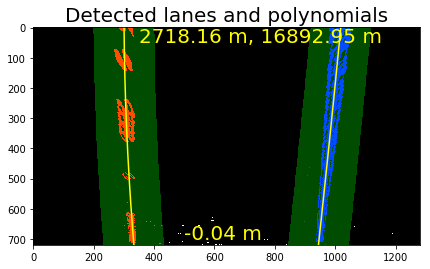

In [1307]:
# Initialization
fitted.left = []
fitted.right = []
firstFrameProcessed.done = False 

lanes, leftFitX, rightFitX, plotY, leftCurveRadius, rightCurveRadius, position = findLanes(warped)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.imshow(lanes)
ax.set_title('Detected lanes and polynomials', fontsize=20)
ax.plot(leftFitX, plotY, color='yellow')
ax.plot(rightFitX, plotY, color='yellow')
ax.text(350, 50,'%.2f m, %.2f m' % (leftCurveRadius, rightCurveRadius), color='yellow', fontsize=20)
ax.text(500, 700, '%.2f m' % position, color='yellow', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'lanes_polynomials.jpg'))

## Step 5

* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Step 5 Functions


In [1308]:
def projectLanes(originalImage, undistorted, warped, inversePerspective, leftFitX, rightFitX, plotY):
    '''
    Create the original image with the lane boundaries
    '''
    zeroWarp = np.zeros_like(warped).astype(np.uint8)
    colorWarp = np.dstack((zeroWarp, zeroWarp, zeroWarp))

    # Recast the x and y points into usable format for cv2.fillPoly()
    leftPoints = np.array([np.transpose(np.vstack([leftFitX, plotY]))])
    rightPoints = np.array([np.flipud(np.transpose(np.vstack([rightFitX, plotY])))])
    points = np.hstack((leftPoints, rightPoints))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(colorWarp, np.int_([points]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix
    # Combine the result with the original image
    backed = cv2.warpPerspective(colorWarp, inversePerspective, (originalImage.shape[1], originalImage.shape[0]))
    return cv2.addWeighted(undistorted, 1, backed, 0.3, 0)

### Step 5 Test

* Creation of the original image with the lane boundaries


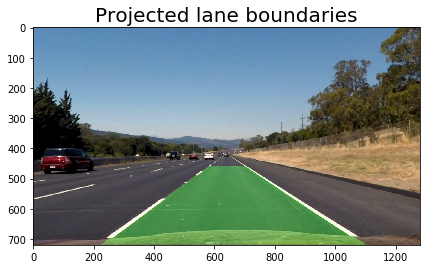

In [1309]:
projected = projectLanes(image, undistorted, warped, inversePerspective, leftFitX, rightFitX, plotY)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.imshow(projected)
ax.set_title('Projected lane boundaries', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'projected.jpg'))

## Pipeline to process a video


In [ ]:
fitted.left = []
fitted.right = []
firstFrameProcessed.done = False 

font = cv2.FONT_HERSHEY_COMPLEX
fontSize = 1
color = (255, 255, 255)
thickness = 2

def pipeline(image):
    '''
    Process each frame of a video to map lane boundaries
    '''
    undistorted = undistort(image, objPoints, imagePoints)
    combinedBinary, colorBinary = thresholdColorGradient(undistorted)
    warped, inversePerspective = warp(combinedBinary)
    lanes, leftFitX, rightFitX, plotY, leftCurveRadius, rightCurveRadius, position = findLanes(warped)
    projected = projectLanes(image, undistorted, warped, inversePerspective, leftFitX, rightFitX, plotY)
    
    cv2.putText(projected,'Radius of curvature = L %.2f m, R %.2f m' % (leftCurveRadius, rightCurveRadius), (100, 50), font, fontSize, color, thickness)
    cv2.putText(projected, 'Vehicle position = %.2f m from center' % position, (100, 100), font, fontSize, color, thickness)
    
    return projected

In [1239]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [1240]:
projectOutput = 'project.mp4'
clipProject = VideoFileClip("project_video.mp4")
projectClip = clipProject.fl_image(pipeline)
%time projectClip.write_videofile(projectOutput, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [15:44<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 16min 3s, sys: 2.96 s, total: 16min 6s
Wall time: 15min 46s


In [1241]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(projectOutput))